In [1]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import librosa
import re
import nltk

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 14
sns.set_style('darkgrid')

In [37]:
data = pd.read_csv("../input/spanish-single-speaker-speech-dataset/transcript.txt",delimiter='|',header=None)
data.columns = ['audio','transcript','normalized_transcript','duration']
data.dropna(inplace=True)

# Spanish Audio Files
- Audio files
- Trasncript of corresponding Audio file

<img src='https://cdn.dictanote.co/static/img/mic-and-keyboard.gif'>

In [38]:
data

,audio,transcript,normalized_transcript,duration
0,19demarzo/19demarzo_0000.wav,Durante nuestra conversación advertí que la mu...,Durante nuestra conversación advertí que la mu...,5.88
1,19demarzo/19demarzo_0001.wav,Componíanla personas de ambos sexos y de todas...,Componíanla personas de ambos sexos y de todas...,4.52
2,19demarzo/19demarzo_0002.wav,espontáneamente venidas por uno de esos llamam...,espontáneamente venidas por uno de esos llamam...,8.31
3,19demarzo/19demarzo_0003.wav,y resuenan de improviso en los oídos de un pue...,y resuenan de improviso en los oídos de un pue...,7.20
4,19demarzo/19demarzo_0004.wav,La campana de ese arrebato glorioso no suena s...,La campana de ese arrebato glorioso no suena s...,7.50
...,...,...,...,...
11105,batalla_arapiles/batalla_arapiles_4592.wav,adquirí lo que llamaban los antiguos aurea med...,adquirí lo que llamaban los antiguos aurea med...,8.06
11106,batalla_arapiles/batalla_arapiles_4593.wav,tuve y tengo un ejército brillante de descendi...,tuve y tengo un ejército brillante de descendi...,8.18
11107,batalla_arapiles/batalla_arapiles_4594.wav,"No me atrevo a deciros que me imitéis, porque ...","No me atrevo a deciros que me imitéis, porque ...",7.92
11108,batalla_arapiles/batalla_arapiles_4595.wav,si encontráis ante vuestros ojos montañas esca...,si encontráis ante vuestros ojos montañas esca...,9.07


In [39]:
data['audio'] = data['audio'].apply(lambda x: os.path.join("../input/spanish-single-speaker-speech-dataset/",x))
data = data.sample(10000).reset_index(drop=True)
data

,audio,transcript,normalized_transcript,duration
0,../input/spanish-single-speaker-speech-dataset...,pero no había visto nada comparable a los ingl...,pero no había visto nada comparable a los ingl...,8.12
1,../input/spanish-single-speaker-speech-dataset...,"Por más que D. Mauro atronó la casa, no pudo c...","Por más que Don Mauro atronó la casa, no pudo ...",8.50
2,../input/spanish-single-speaker-speech-dataset...,Lo más singular de la determinaciónde aquellos...,Lo más singular de la de aquellos cortesanos t...,8.28
3,../input/spanish-single-speaker-speech-dataset...,y habiendo ocasionado a usted tantos disgustos...,y habiendo ocasionado a usted tantos disgustos...,9.33
4,../input/spanish-single-speaker-speech-dataset...,donde le entregaron los pliegos de Reding.,donde le entregaron los pliegos de Reding.,4.02
...,...,...,...,...
9995,../input/spanish-single-speaker-speech-dataset...,¿No os volvéis a vuestro pueblo? No he visto m...,¿No os volvéis a vuestro pueblo? No he visto m...,8.20
9996,../input/spanish-single-speaker-speech-dataset...,Otros hicieron una grande hoguera con los carr...,Otros hicieron una grande hoguera con los carr...,8.74
9997,../input/spanish-single-speaker-speech-dataset...,"insiste mucho en esto, ¿eh?, dile que nos vamo...","insiste mucho en esto, ¿eh?, dile que nos vamo...",9.88
9998,../input/spanish-single-speaker-speech-dataset...,y era un ancho cinturón de cuero con diversos ...,y era un ancho cinturón de cuero con diversos ...,7.91


In [40]:
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Feature Extraction
- MFCC Feature Extraction

<img src='https://mitll.github.io/pyslgr/images/mfcc/mfcc_overview.jpeg'>

In [41]:
def feature_extraction(df):
    features = {}
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['audio'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)
            features[record['audio']] = mean_mfcc
        except EOFError:
            pass
        
    return features

In [42]:
acoustic_features = feature_extraction(data)

100%|██████████| 10000/10000 [05:04<00:00, 32.87it/s]


# Text Preprocessing and Structuring

<img src='https://iq.opengenus.org/content/images/2019/12/1_XvUt5wDQA8D3C0wAuxAvbA.png'>

In [43]:
def text_preprocessing(data):
    data['transcript'] = data['transcript'].apply(lambda x: x.lower())
    data['transcript'] = data['transcript'].apply(lambda x: re.sub("[^A-Za-z]"," ",x))
    data['transcript'] = data['transcript'].apply(lambda x: re.sub("\s+"," ",x))
    data['transcript'] = data['transcript'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['transcript'] = "startseq "+data['transcript']+" endseq"
    return data

In [44]:
data = text_preprocessing(data)
transcripts = data['transcript'].tolist()
transcripts[:10]

['startseq pero no hab visto nada comparable los ingleses tratando de resistir yo no hab visto que las columnas se dejaran acuchillar endseq',
 'startseq por que mauro atron la casa no pudo conseguir que in se disfrazara con el guardapi verde las medias encarnadas las azules botas endseq',
 'startseq lo singular de la determinaci nde aquellos cortesanos tiznados con el holl de la demagogia era que disputaban sobre qui deb llevarlas endseq',
 'startseq habiendo ocasionado usted tantos disgustos congojas mortales ansias acalorados paroxismos parec natural que la tomase usted en aborrecimiento endseq',
 'startseq donde le entregaron los pliegos de reding endseq',
 'startseq carlos el temerario era artillero llevaba un machete corto arma de escaso valor en aquella ocasi endseq',
 'startseq en fin dijo la condesa los rumores circularon yo misma lo supe pero la cosa no vale la pena si la gran breta se mantiene sin mancilla endseq',
 'startseq parec que le estorbaban sus propiasmanos endseq',

In [45]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(transcripts)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(transcript.split()) for transcript in transcripts)

# Transcript Length Distribution

<AxesSubplot:ylabel='Count'>

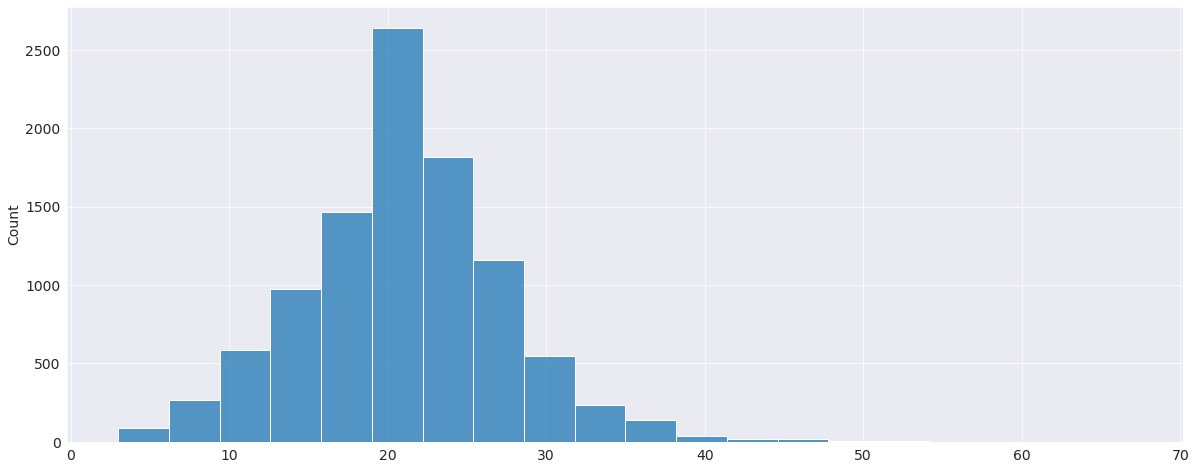

In [46]:
sns.histplot([len(transcript.split()) for transcript in transcripts],bins=20)

In [47]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, tokenizer, 
                 vocab_size, max_length, features, shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        audios = batch[self.X_col].tolist()
           
        for audio in audios:
            feature = self.features[audio]
            
            captions = batch.loc[batch[self.X_col]==audio, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

In [48]:
train = data.iloc[:8500,:]
test = data.iloc[8500:,:]

In [49]:
train_generator = CustomDataGenerator(df=train,X_col='audio',y_col='transcript',batch_size=64,tokenizer=tokenizer,
                                      vocab_size=vocab_size,max_length=25,features=acoustic_features)

test_generator = CustomDataGenerator(df=test,X_col='audio',y_col='transcript',batch_size=64,tokenizer=tokenizer,
                                      vocab_size=vocab_size,max_length=25,features=acoustic_features)

# Model

<img src='https://developer.nvidia.com/blog/wp-content/uploads/2019/03/pasted-image-0-19.png'>

In [50]:
input1 = Input(shape=(128,1))
input2 = Input(shape=(25,))

feature_model = Conv1D(16, 11, activation='relu', padding = "same")(input1)
feature_model = BatchNormalization()(feature_model)
feature_model = MaxPooling1D(3)(feature_model)
feature_model = Conv1D(32, 9, activation='relu', padding = "same")(feature_model)
feature_model = BatchNormalization()(feature_model)
feature_model = MaxPooling1D(3)(feature_model)
feature_model = Conv1D(64, 7, activation='relu', padding = "same")(feature_model)
feature_model = BatchNormalization()(feature_model)
feature_model = MaxPooling1D(3)(feature_model)
feature_model = Flatten()(feature_model)
feature_model = Dense(256, activation='relu')(feature_model)

# LSTM  model
seq_model = Embedding(vocab_size, 128, mask_zero=True)(input2)
seq_model = LSTM(256)(seq_model)
# Merging both models
decoder = add([feature_model, seq_model])
decoder = Dense(256, activation='relu')(decoder)
output = Dense(vocab_size, activation='softmax')(decoder)


caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [51]:
caption_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 128, 16)      192         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 128, 16)      64          conv1d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_6 (MaxPooling1D)  (None, 42, 16)       0           batch_normalization_6[0][0]      
____________________________________________________________________________________________

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [53]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.3, 
                                            min_lr=0.00000001)

In [54]:
history = caption_model.fit(train_generator,
                            validation_data=test_generator,
                            epochs=50)

Epoch 1/50
132/132 [==============================] - 55s 383ms/step - loss: 7.2106 - val_loss: 7.0338
Epoch 2/50
132/132 [==============================] - 48s 364ms/step - loss: 6.7315 - val_loss: 6.9587
Epoch 3/50
132/132 [==============================] - 49s 368ms/step - loss: 6.4625 - val_loss: 6.7927
Epoch 4/50
132/132 [==============================] - 48s 364ms/step - loss: 6.2047 - val_loss: 6.6847
Epoch 5/50
132/132 [==============================] - 49s 372ms/step - loss: 5.9285 - val_loss: 6.6455
Epoch 6/50
132/132 [==============================] - 56s 420ms/step - loss: 5.6423 - val_loss: 6.6885
Epoch 7/50
132/132 [==============================] - 49s 370ms/step - loss: 5.3495 - val_loss: 6.7859
Epoch 8/50
132/132 [==============================] - 50s 375ms/step - loss: 5.0498 - val_loss: 7.0634
Epoch 9/50
132/132 [==============================] - 48s 365ms/step - loss: 4.7502 - val_loss: 7.2975
Epoch 10/50
132/132 [==============================] - 49s 368ms/step - l

# Inference

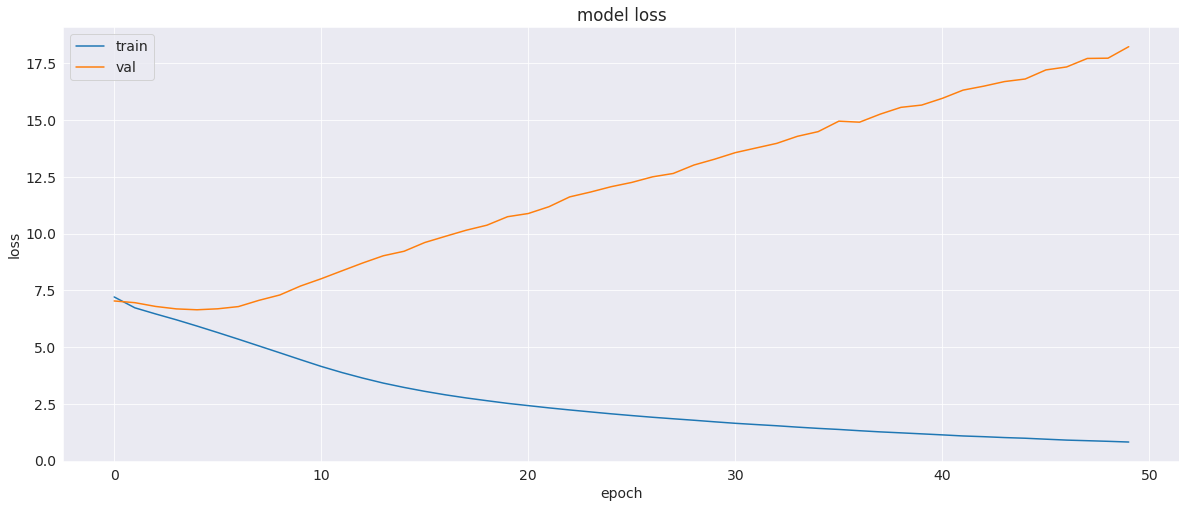

In [55]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [56]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [57]:
def predict_caption(model, audio, tokenizer, max_length, features):
    
    feature = features[audio]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature.reshape(-1,128),sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

In [58]:
test

,audio,transcript,normalized_transcript,duration
8500,../input/spanish-single-speaker-speech-dataset...,startseq cualquiera habr cre do en la existenc...,Cualquiera habría creído en la existencia de u...,4.65
8501,../input/spanish-single-speaker-speech-dataset...,startseq santorcaz quiso hablar pero la emoci ...,"Santorcaz quiso hablar, pero la emoción entorp...",7.65
8502,../input/spanish-single-speaker-speech-dataset...,startseq no puse ni un desperdicio de voluntad...,no puse ni un desperdicio de voluntad en aquel...,6.89
8503,../input/spanish-single-speaker-speech-dataset...,startseq oh pensamos marcharnos pronto porque ...,"-¡Oh! Sí... Pensamos marcharnos pronto, porque...",8.64
8504,../input/spanish-single-speaker-speech-dataset...,startseq en sus breves columnas se insertaban ...,En sus breves columnas se insertaban diariamen...,6.49
...,...,...,...,...
9995,../input/spanish-single-speaker-speech-dataset...,startseq no os volv is vuestro pueblo no he vi...,¿No os volvéis a vuestro pueblo? No he visto m...,8.20
9996,../input/spanish-single-speaker-speech-dataset...,startseq otros hicieron una grande hoguera con...,Otros hicieron una grande hoguera con los carr...,8.74
9997,../input/spanish-single-speaker-speech-dataset...,startseq insiste mucho en esto eh dile que nos...,"insiste mucho en esto, ¿eh?, dile que nos vamo...",9.88
9998,../input/spanish-single-speaker-speech-dataset...,startseq era un ancho cintur de cuero con dive...,y era un ancho cinturón de cuero con diversos ...,7.91


In [59]:
for i in range(10):
    print(test.iloc[i].transcript)
    print(predict_caption(caption_model, test.iloc[i].audio, tokenizer, 25, acoustic_features))
    print("------------------------------------------------------------------")

startseq cualquiera habr cre do en la existencia de una conjuraci silenciosamentepreparada endseq
startseq pesar de que las alegr me cre grandes hombres una plaza donde cada amanecer est sola en acci con lo que menos dec endseq
------------------------------------------------------------------
startseq santorcaz quiso hablar pero la emoci entorpec su lengua quiso re quiso despu ponerse serio aun col rico endseq
startseq despu pasaba all le dej de gracia al menos tan grande poco que tengo ser fuerza que mis desprecio me dijo con su arrojo endseq
------------------------------------------------------------------
startseq no puse ni un desperdicio de voluntad en aquellos movimientos de la quina en que estaba engranado endseq
startseq el espect culo de los dioses nos arroja en el ejemplo de sus dioses nos reconocimos encima de la oscuridad de su hija endseq
------------------------------------------------------------------
startseq oh pensamos marcharnos pronto porque nos llama un asunto e